# SDS to website
Purpose: By processing a list of events from an Excel spreadsheet, look for existing seismic & infrasound data in an SDS archive, instrument correct those data, and make a webpage for each event 

Steps:
1. Create an event catalog with instrument-corrected data

TO DO: 
* add support for AM network, and any data from networks run by other operators and available on IRIS
* add well data from YYYYMMDD_final.pkl files

Do we want to turn pkl files into SDS?

SCAFFOLD:
* add a detector for sonic booms after rocket launch for landers
* add any nearby IRIS seismic and infrasound data

# 1. Do full workflow for all events
* Load and correct seismic and infrasound data from FL network and XA and whatever the network was for PASSCAL equipment

Linux
Linux
Processing launch at 2022-04-01 16:24:16
/home/thompsong/Dropbox/PROFESSIONAL/RESEARCH/3_Project_Documents/NASAprojects/201602_Rocket_Seismology/DATA/2022_DATA/WellData/07_DAILY_WLM/20220401.pkl not found
Processing launch at 2022-04-08 15:17:12
/home/thompsong/Dropbox/PROFESSIONAL/RESEARCH/3_Project_Documents/NASAprojects/201602_Rocket_Seismology/DATA/2022_DATA/WellData/07_DAILY_WLM/20220408.pkl not found
Processing launch at 2022-04-21 17:51:40
/home/thompsong/Dropbox/PROFESSIONAL/RESEARCH/3_Project_Documents/NASAprojects/201602_Rocket_Seismology/DATA/2022_DATA/WellData/07_DAILY_WLM/20220421.pkl not found
Processing launch at 2022-04-27 07:52:55
/home/thompsong/Dropbox/PROFESSIONAL/RESEARCH/3_Project_Documents/NASAprojects/201602_Rocket_Seismology/DATA/2022_DATA/WellData/07_DAILY_WLM/20220427.pkl not found
Processing launch at 2022-04-29 21:27:10
/home/thompsong/Dropbox/PROFESSIONAL/RESEARCH/3_Project_Documents/NASAprojects/201602_Rocket_Seismology/DATA/2022_DATA/WellData

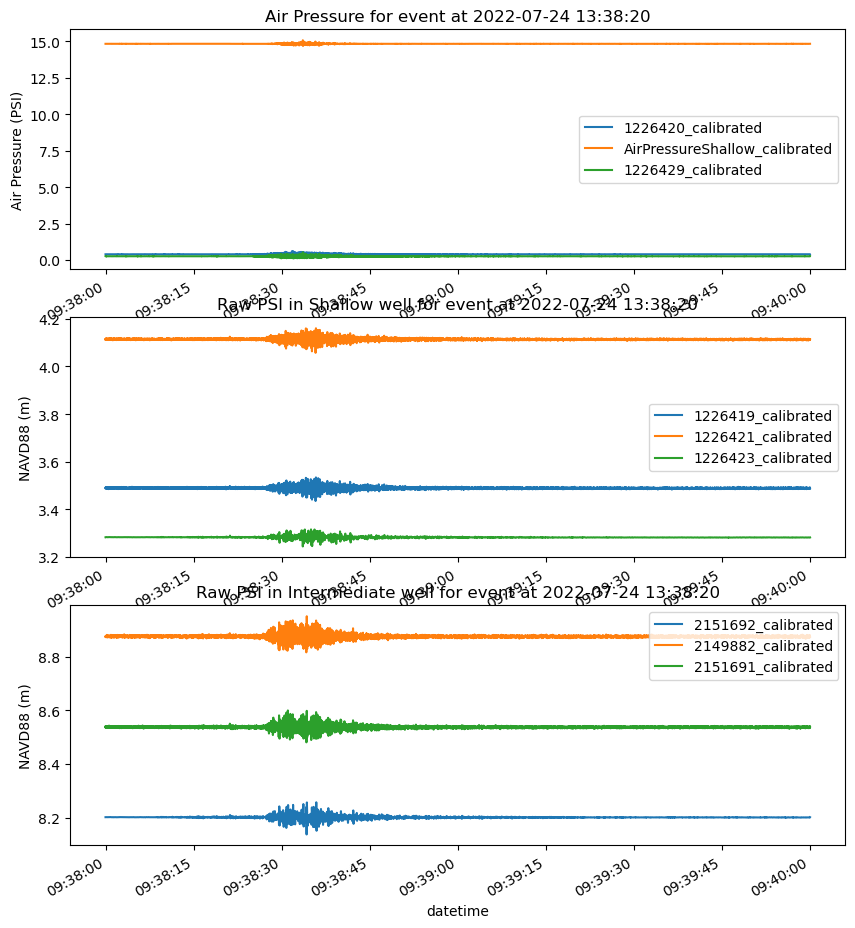

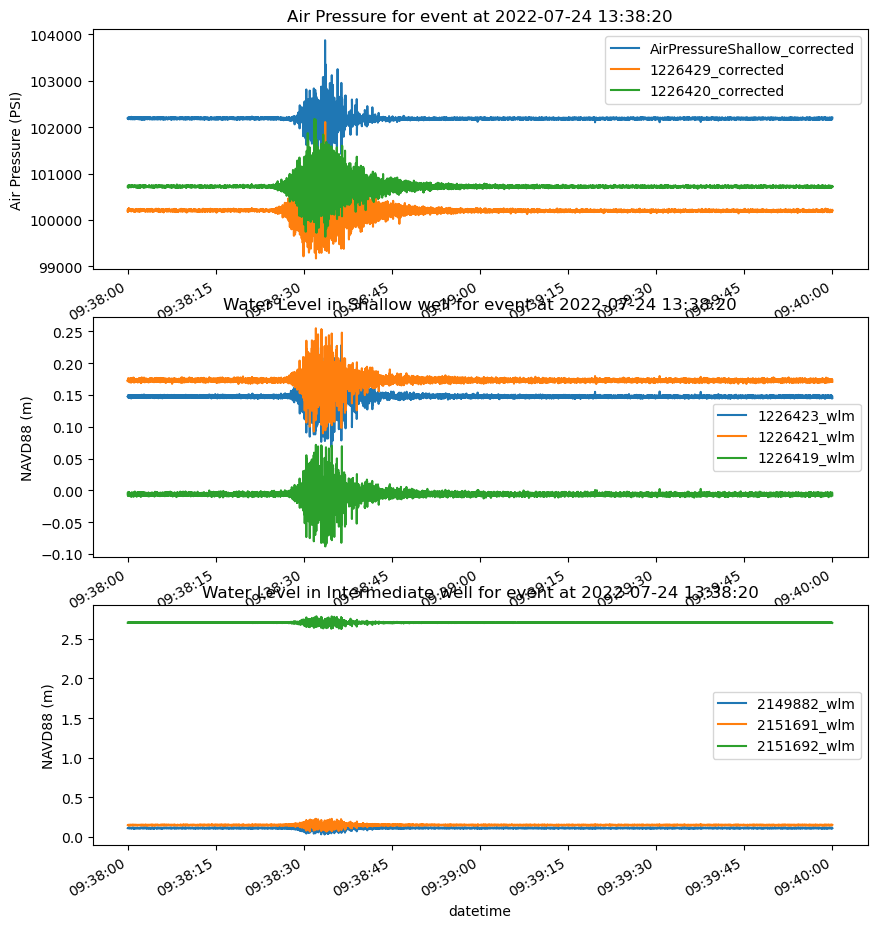

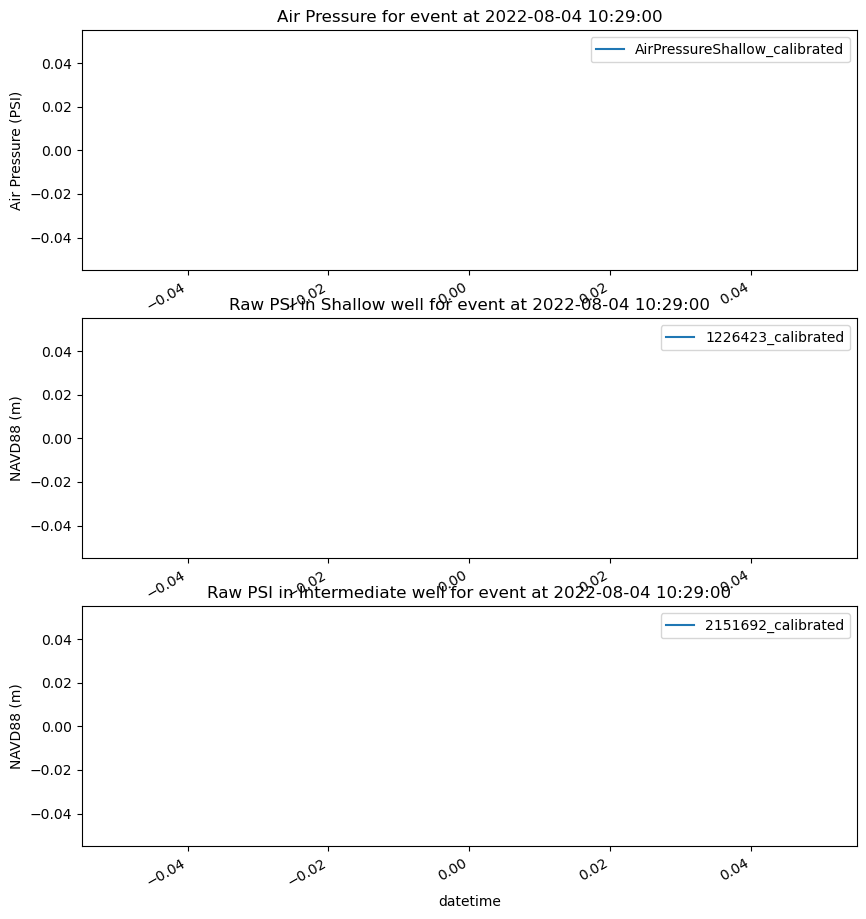

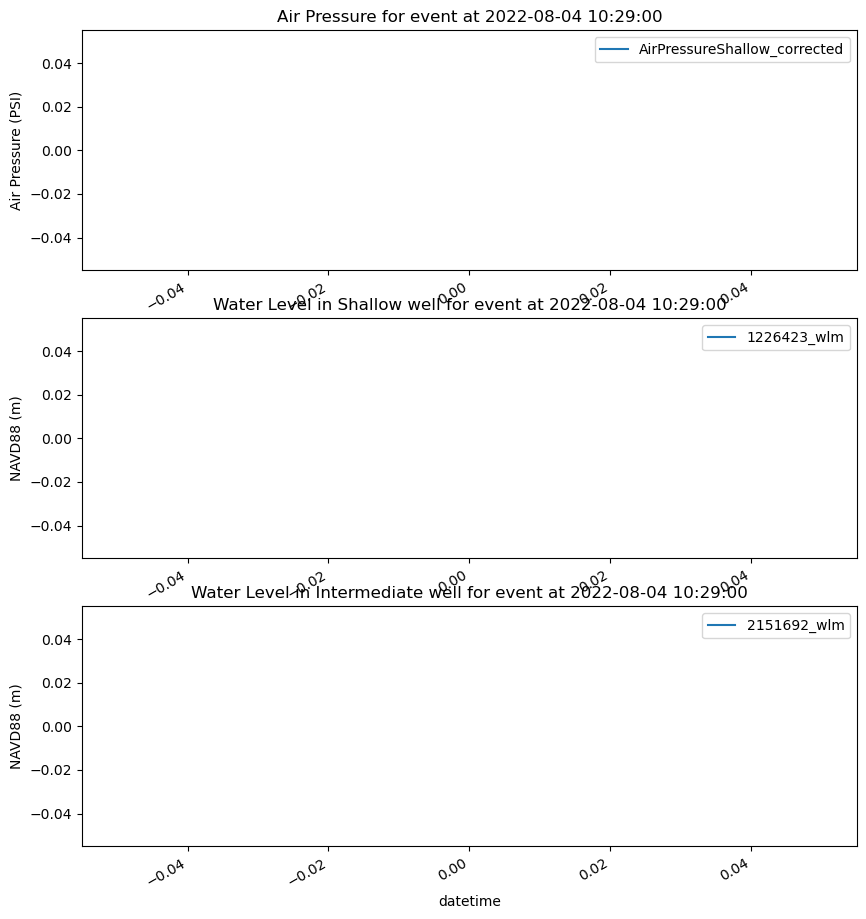

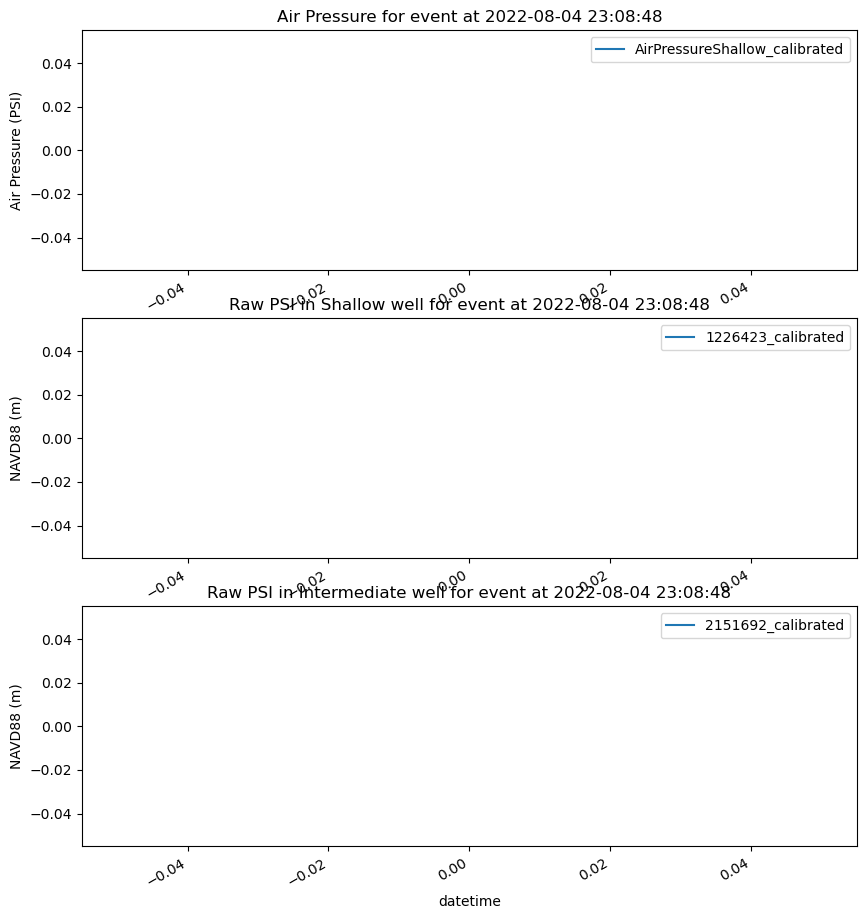

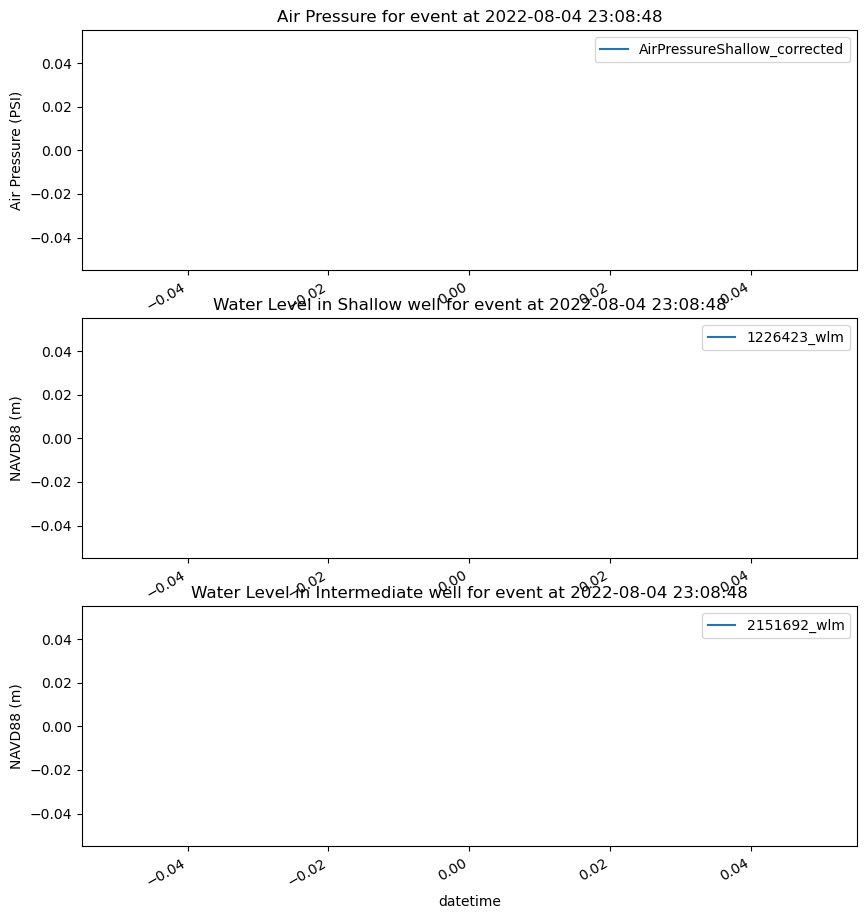

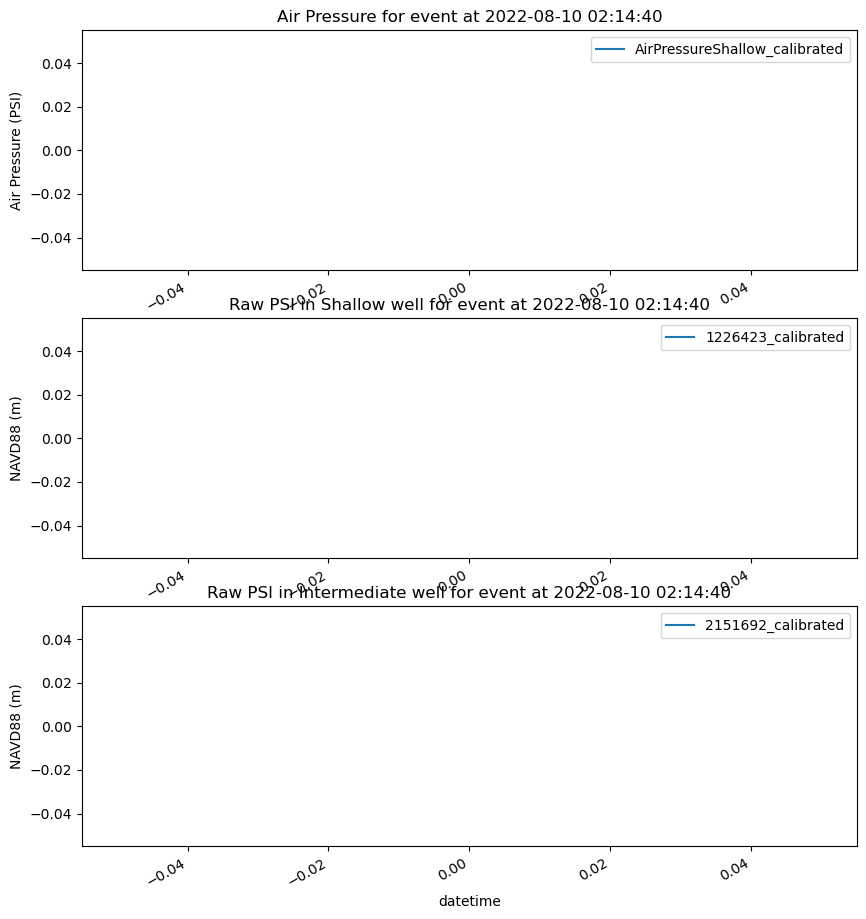

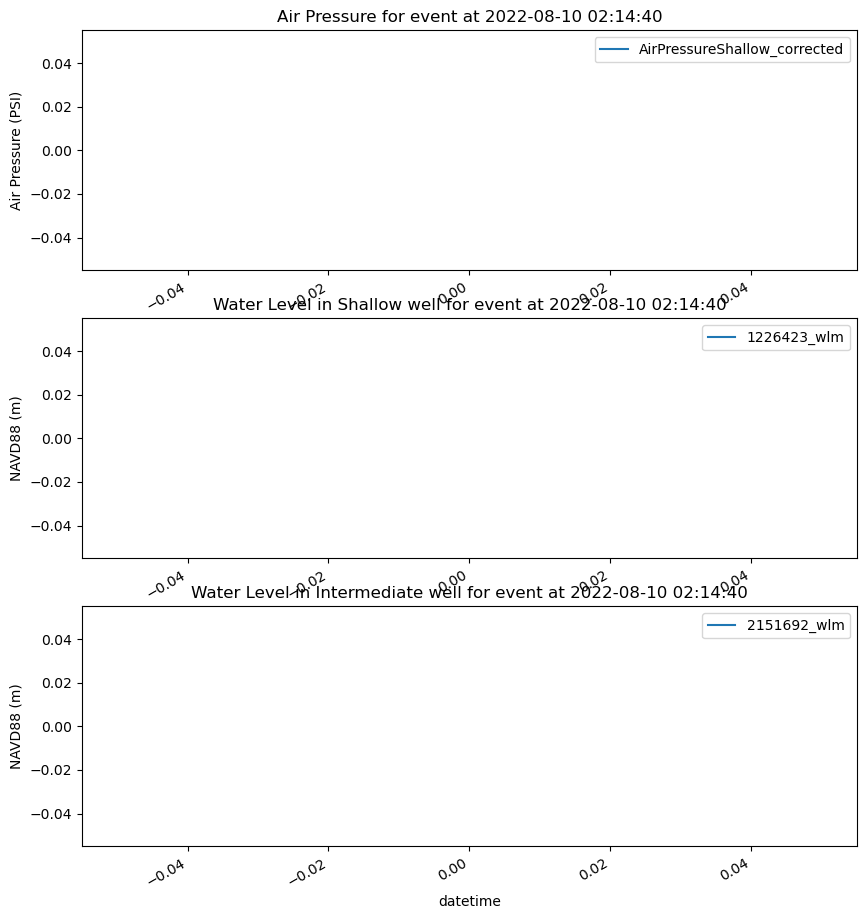

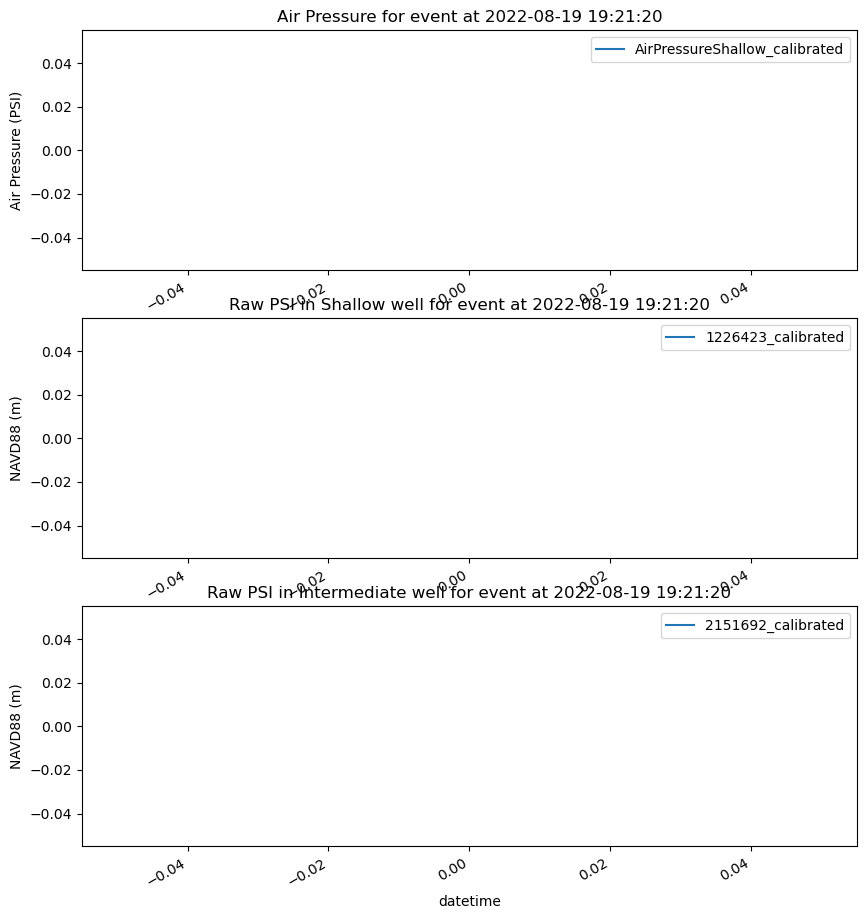

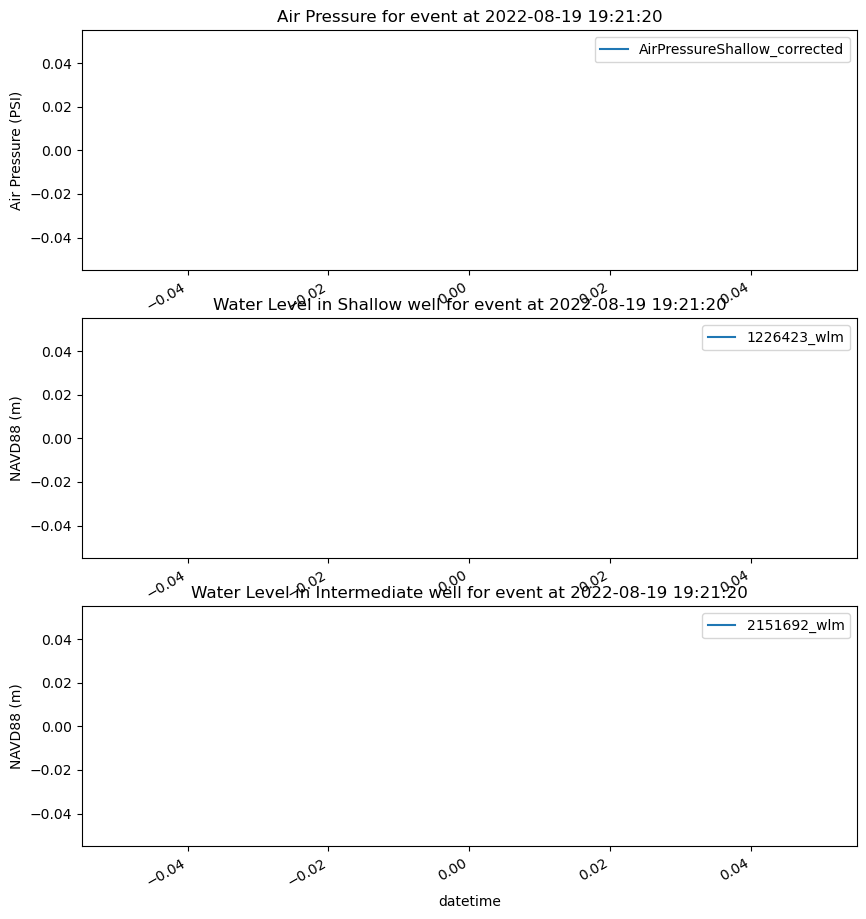

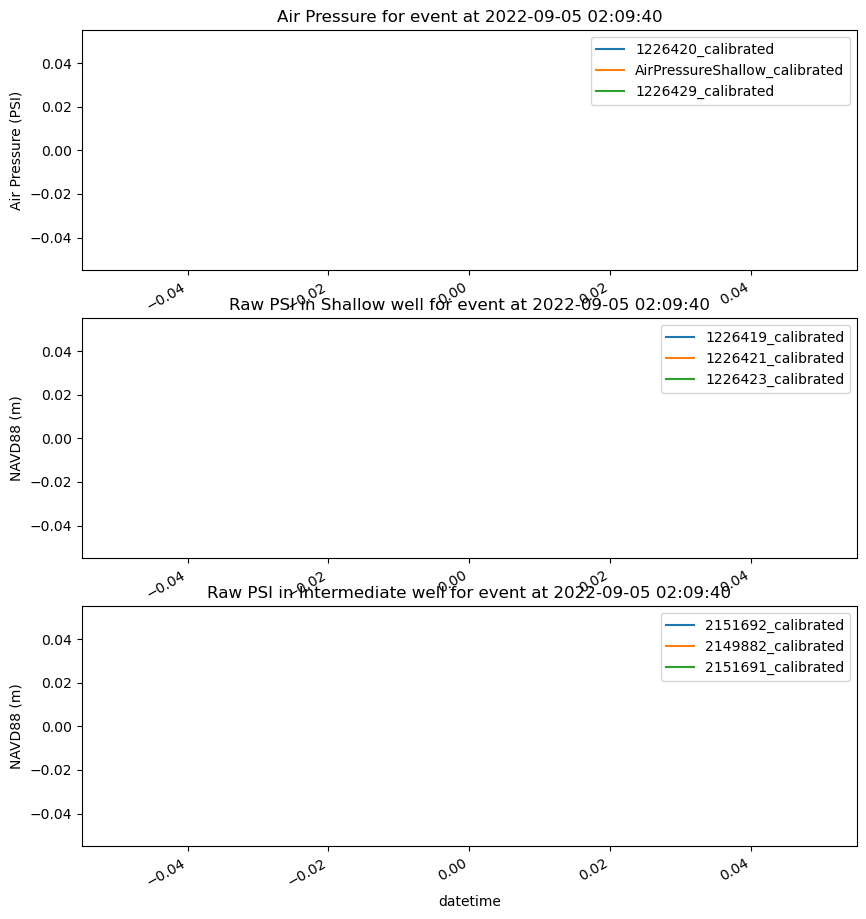

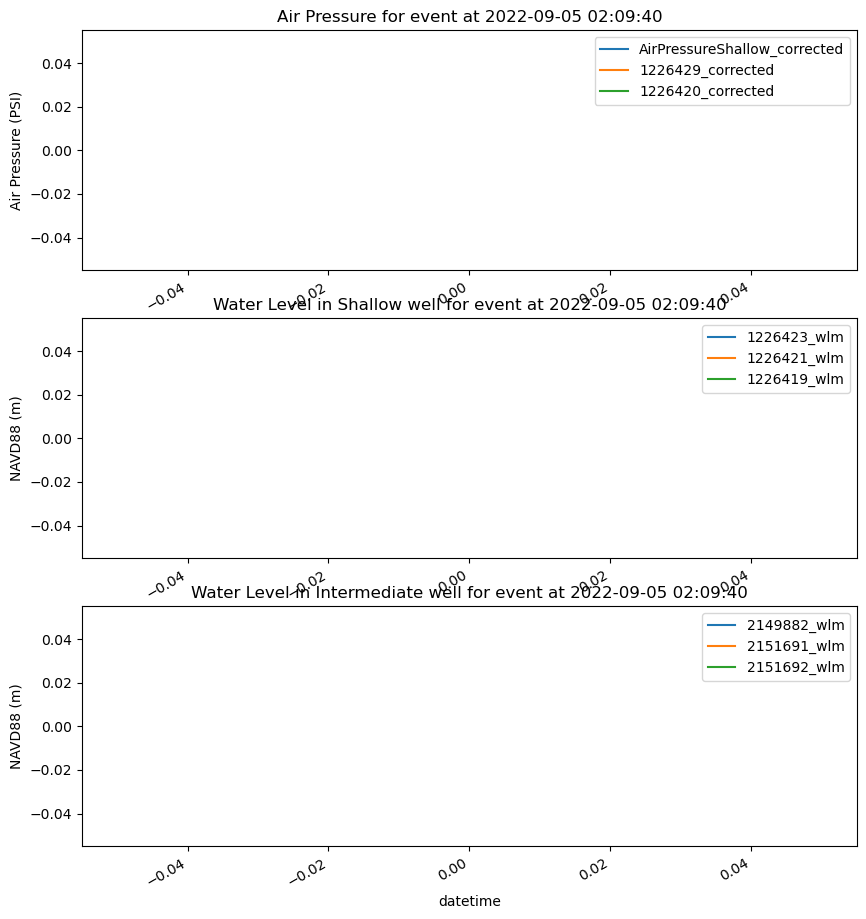

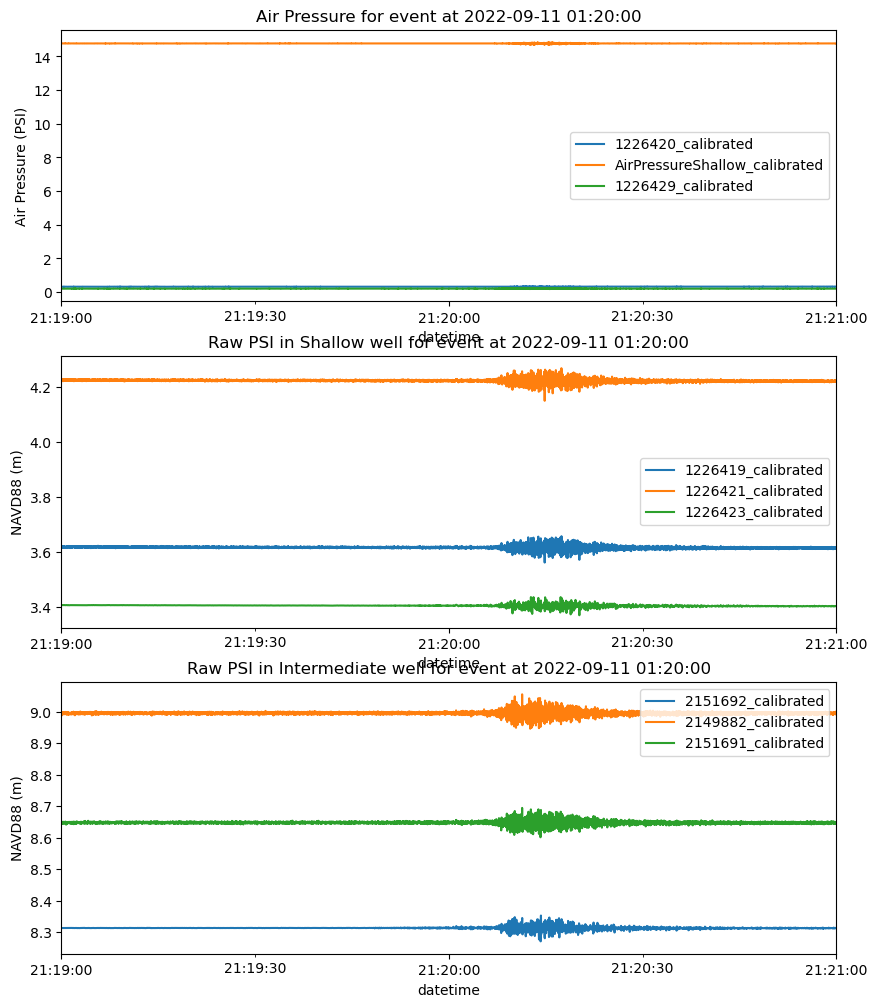

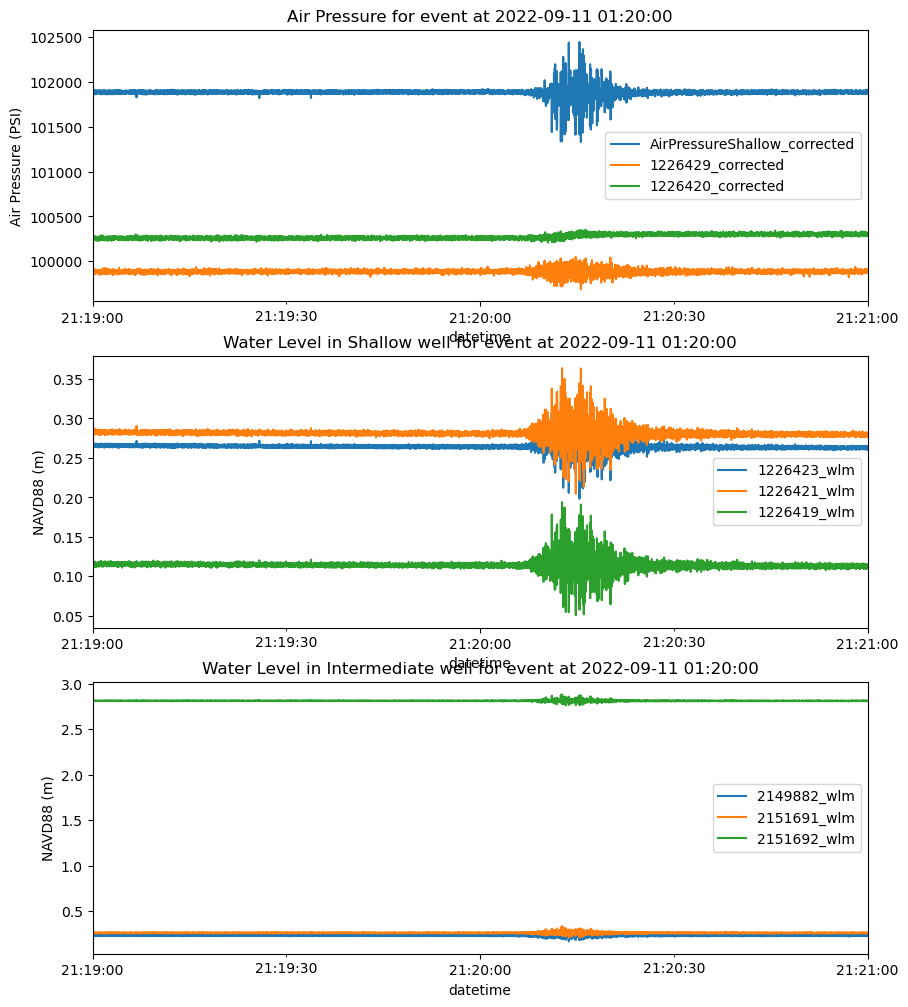

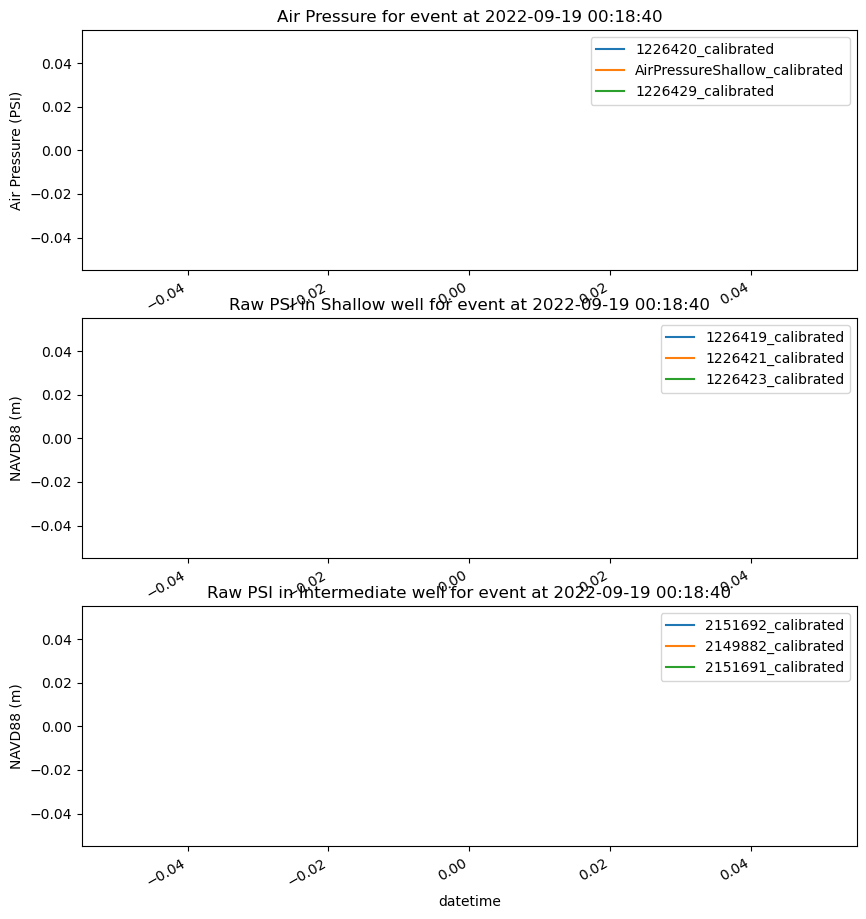

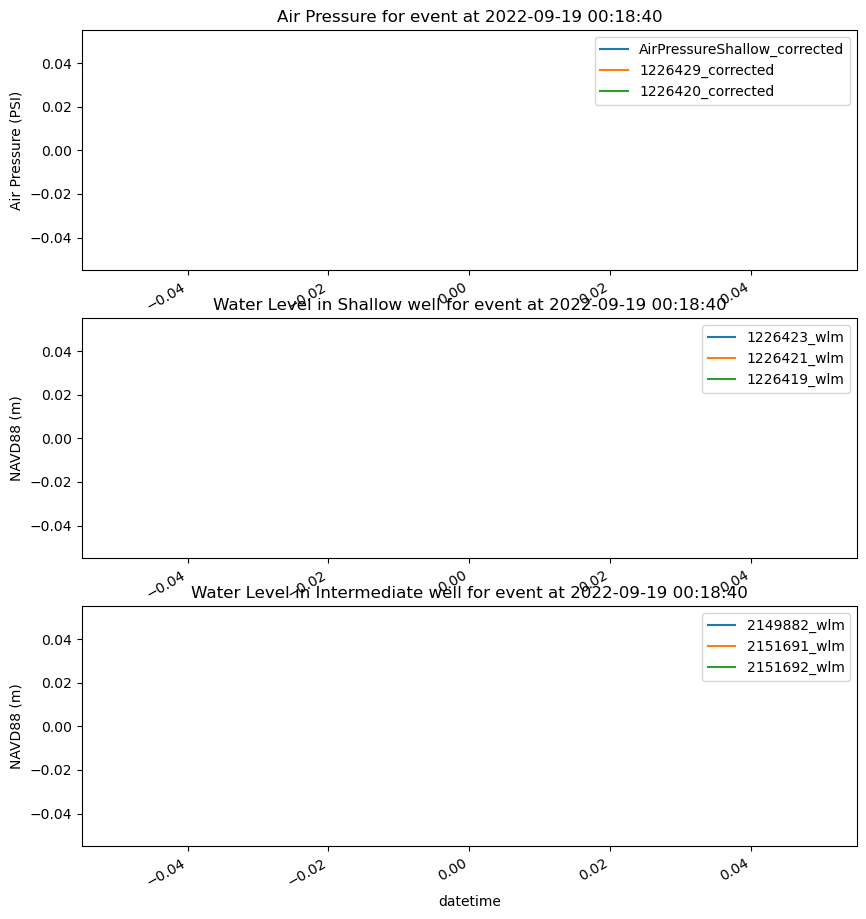

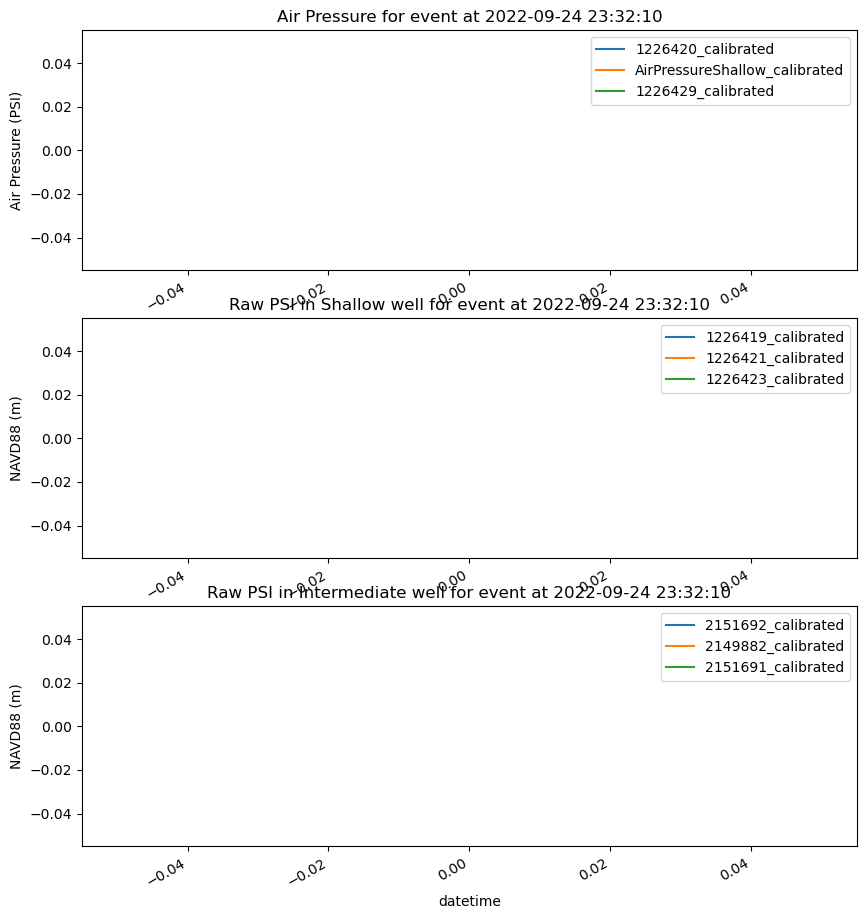

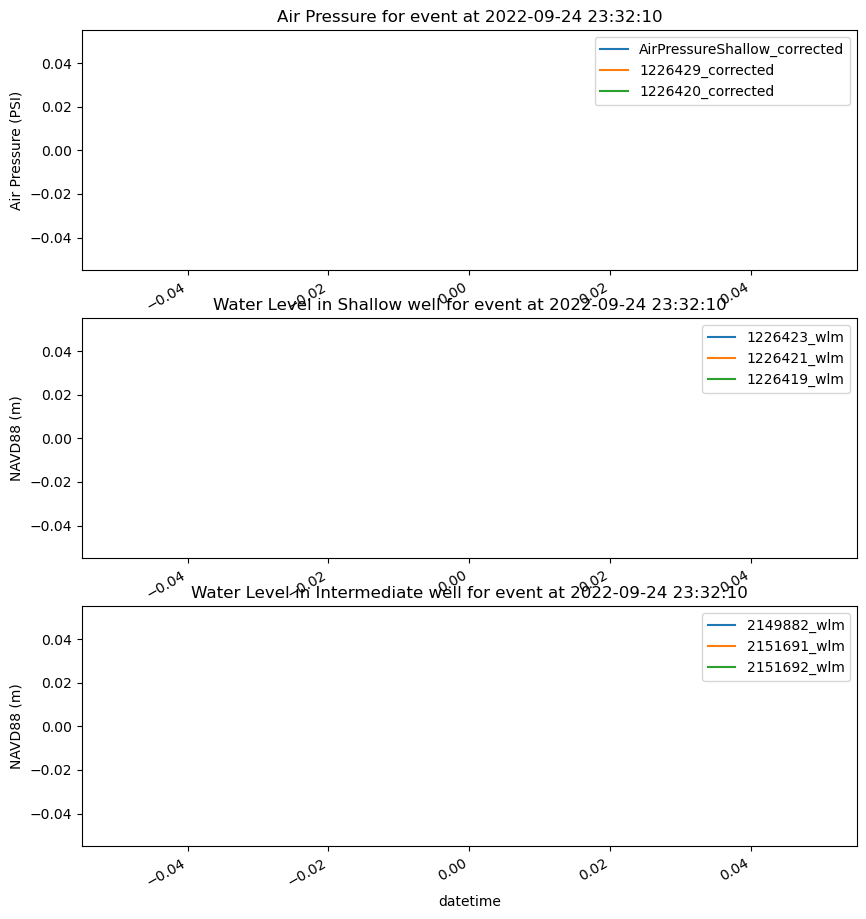

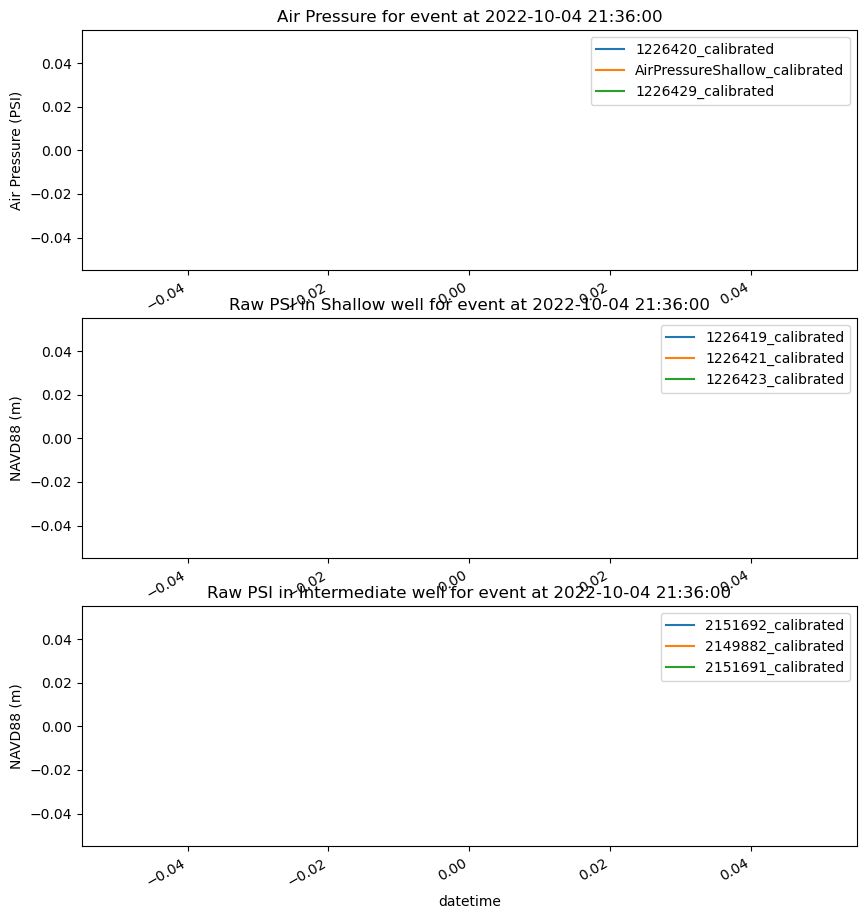

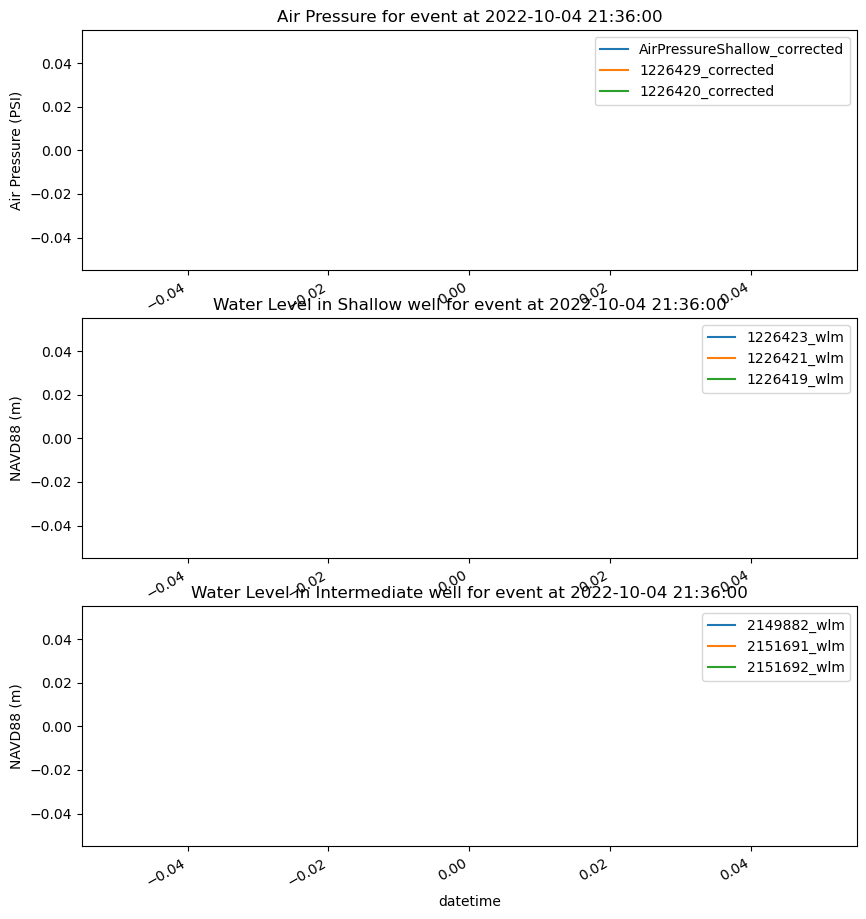

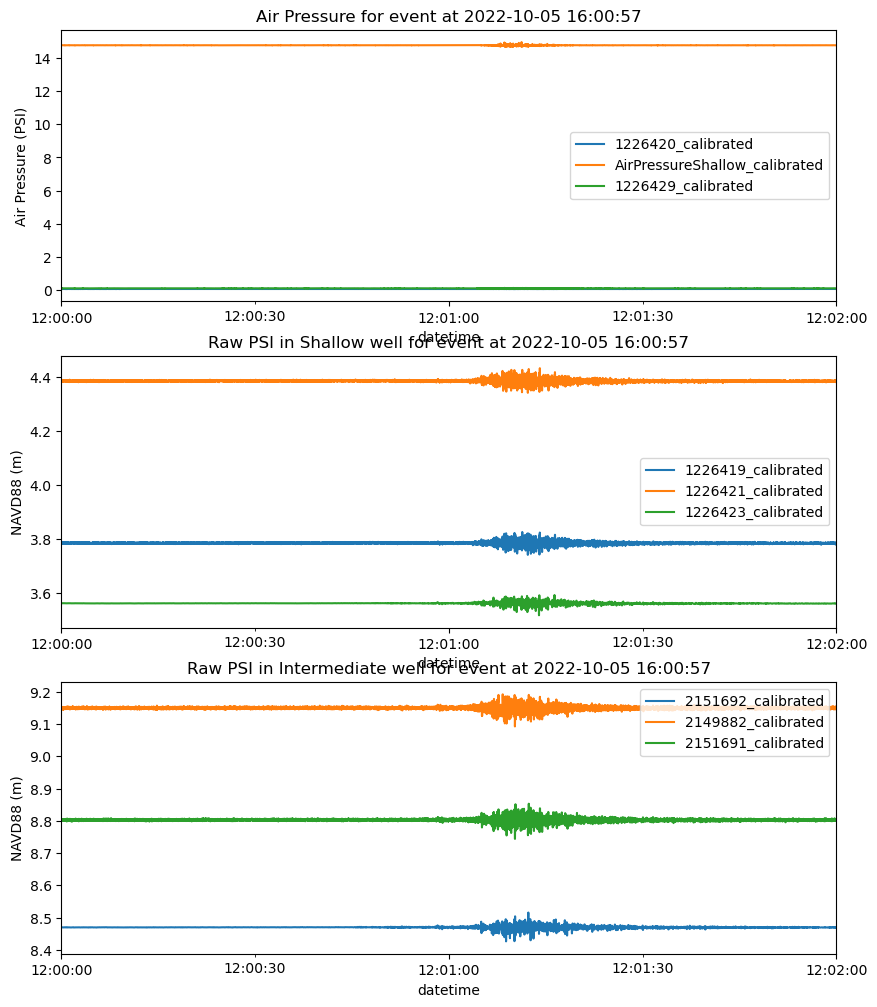

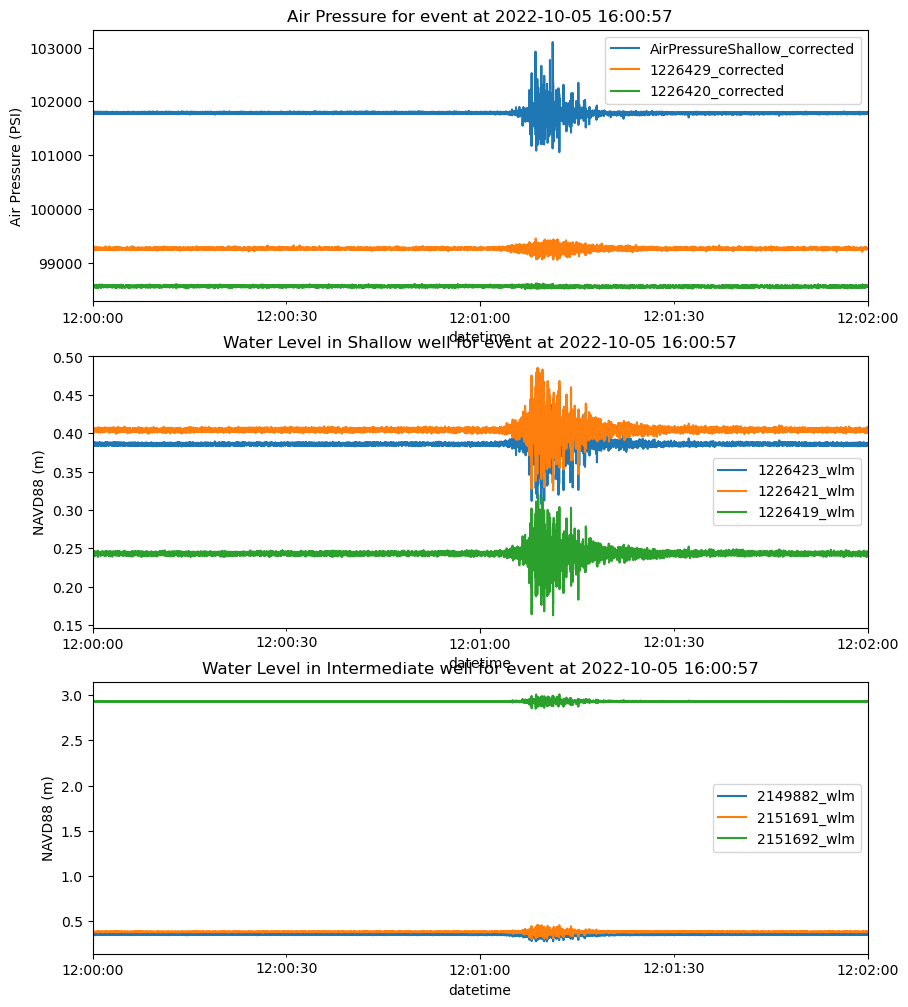

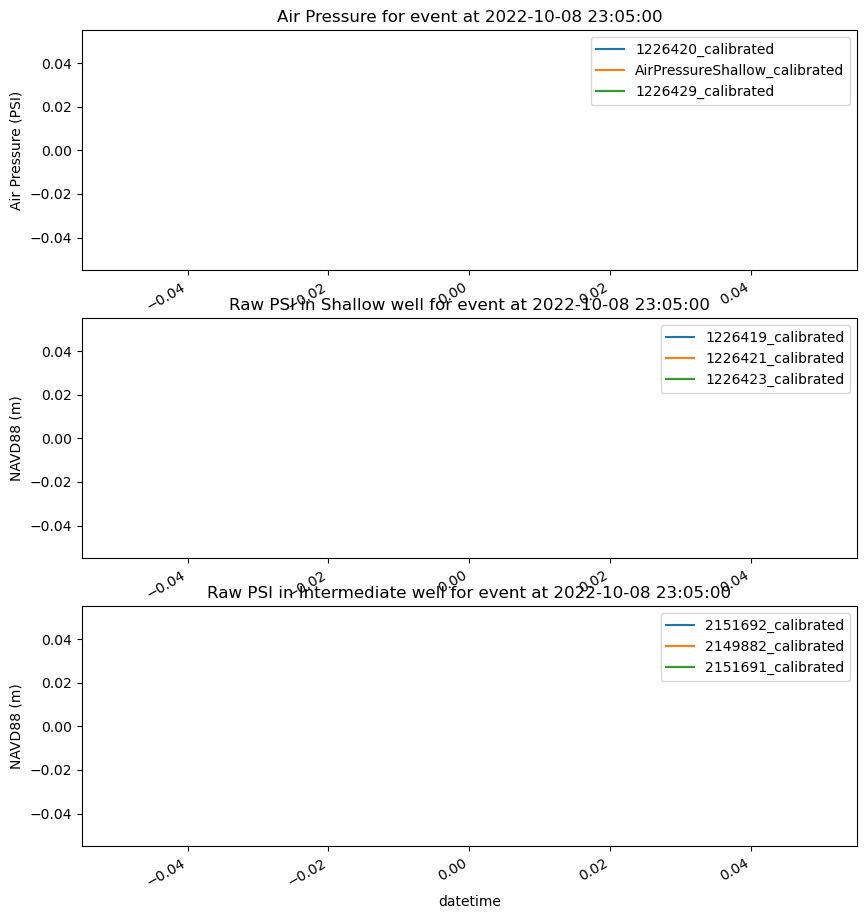

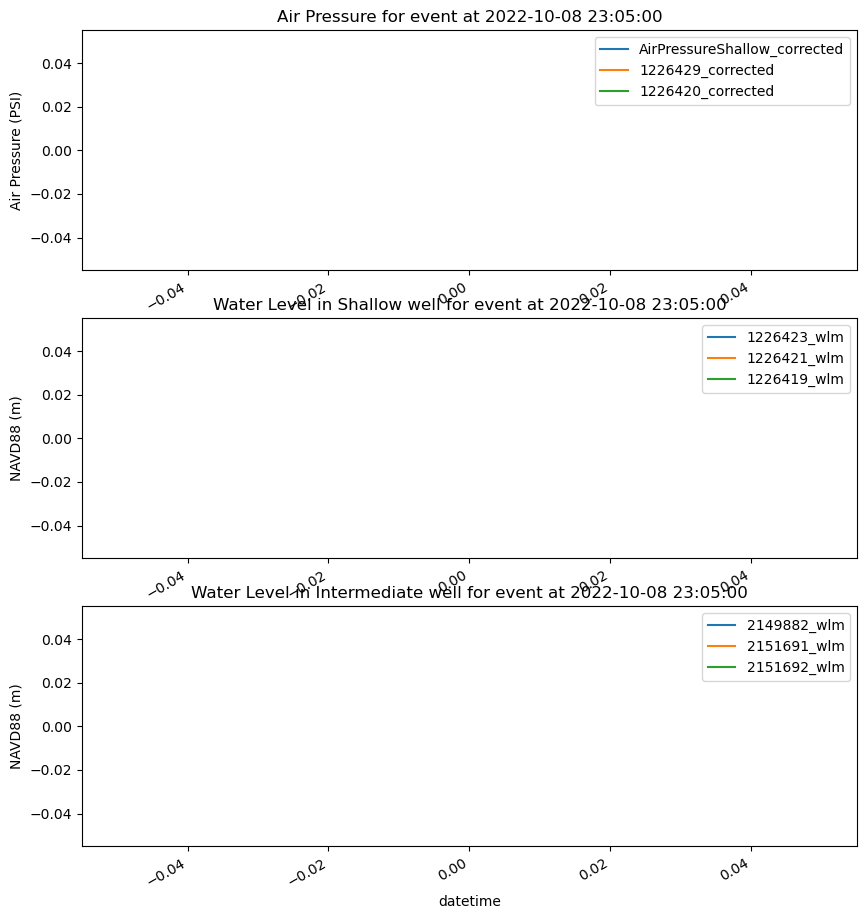

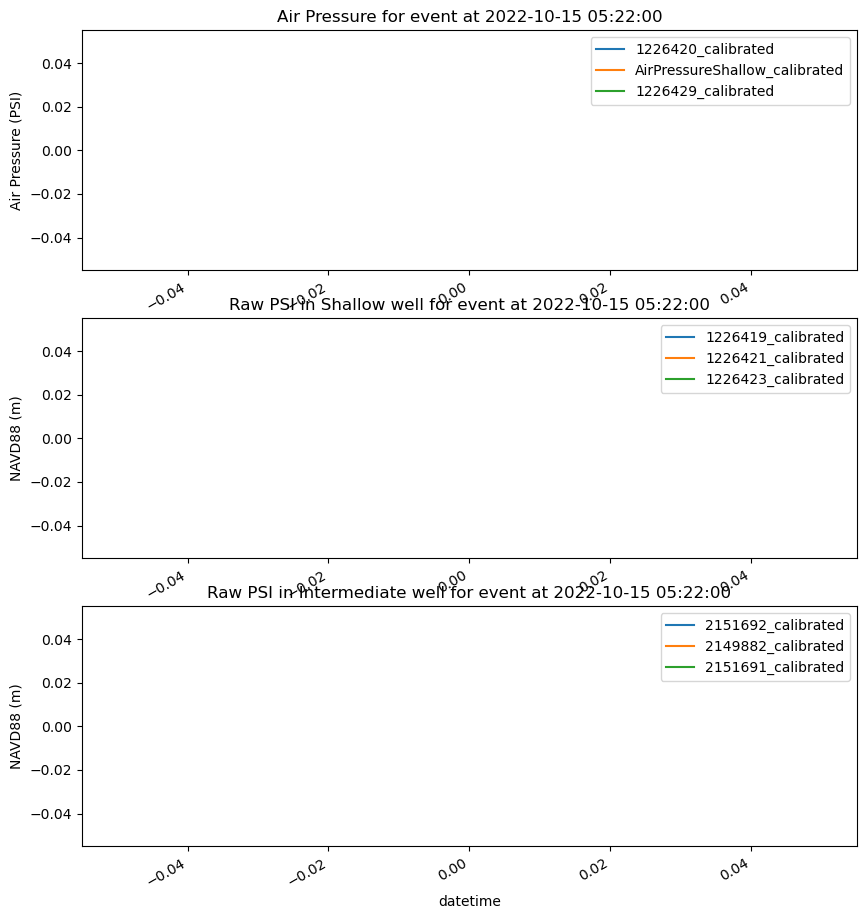

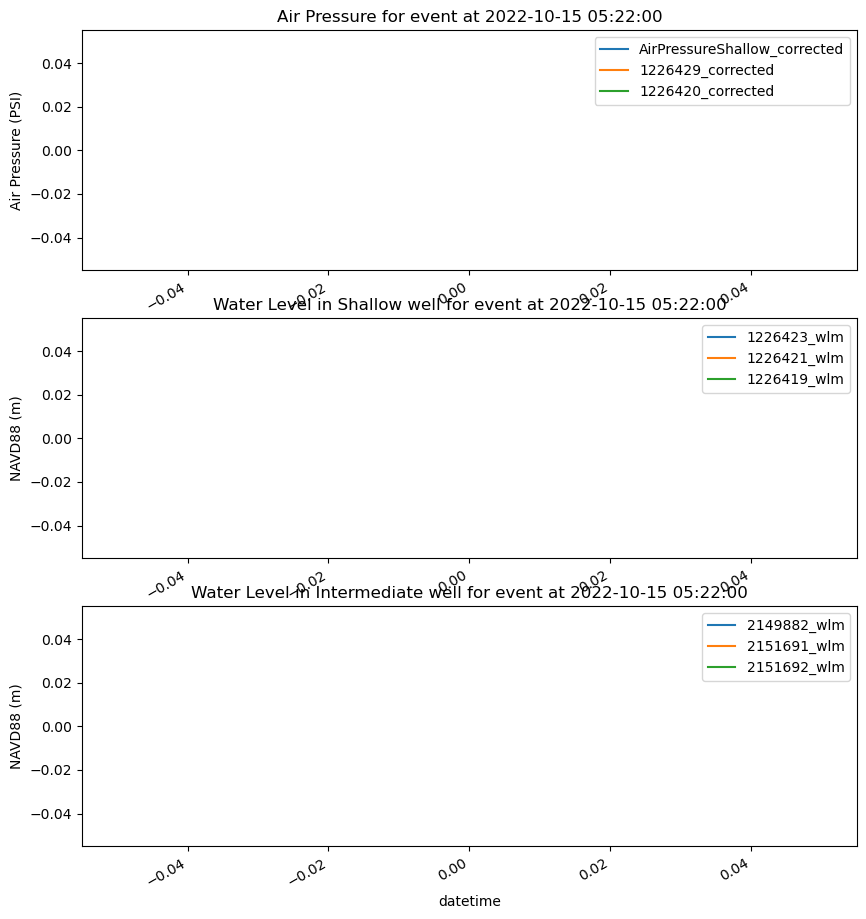

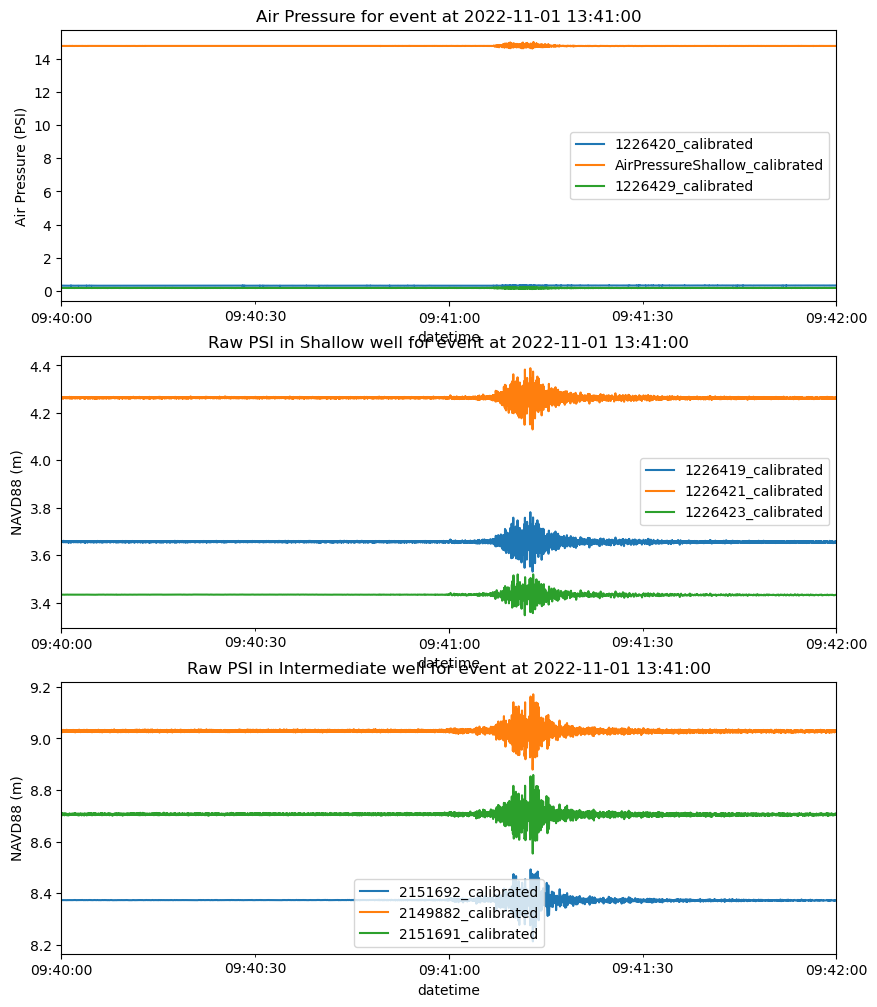

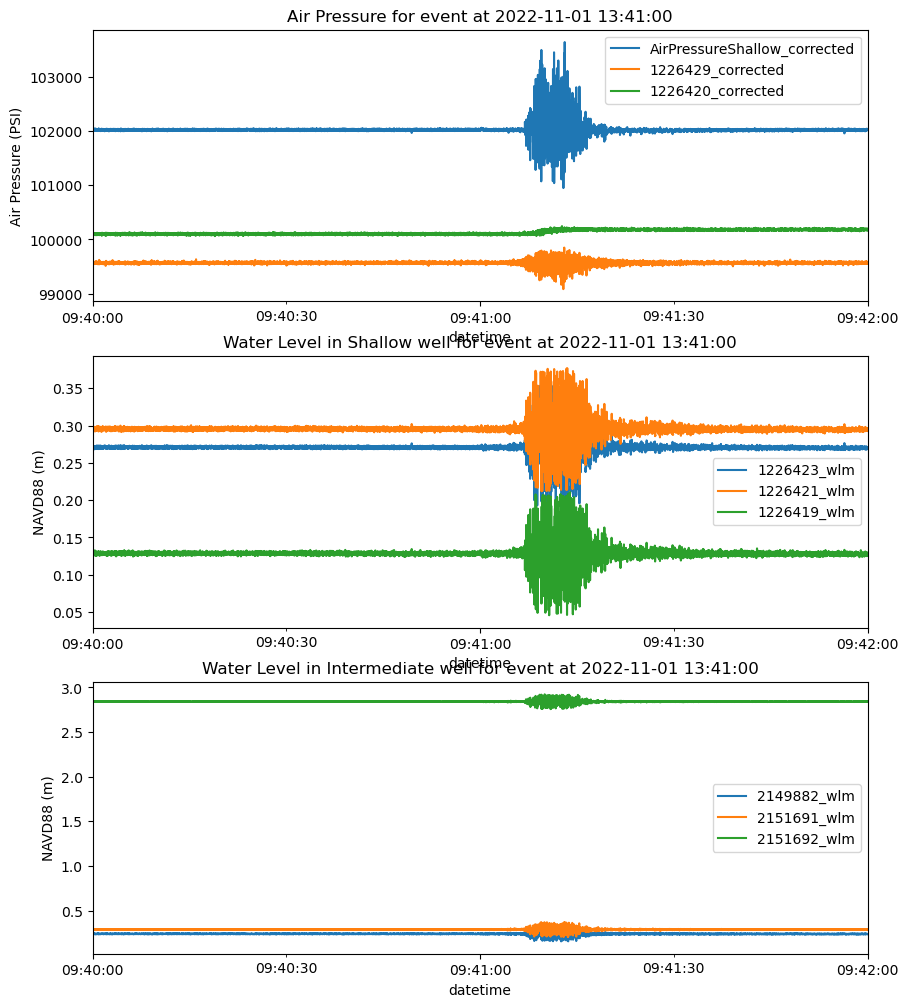

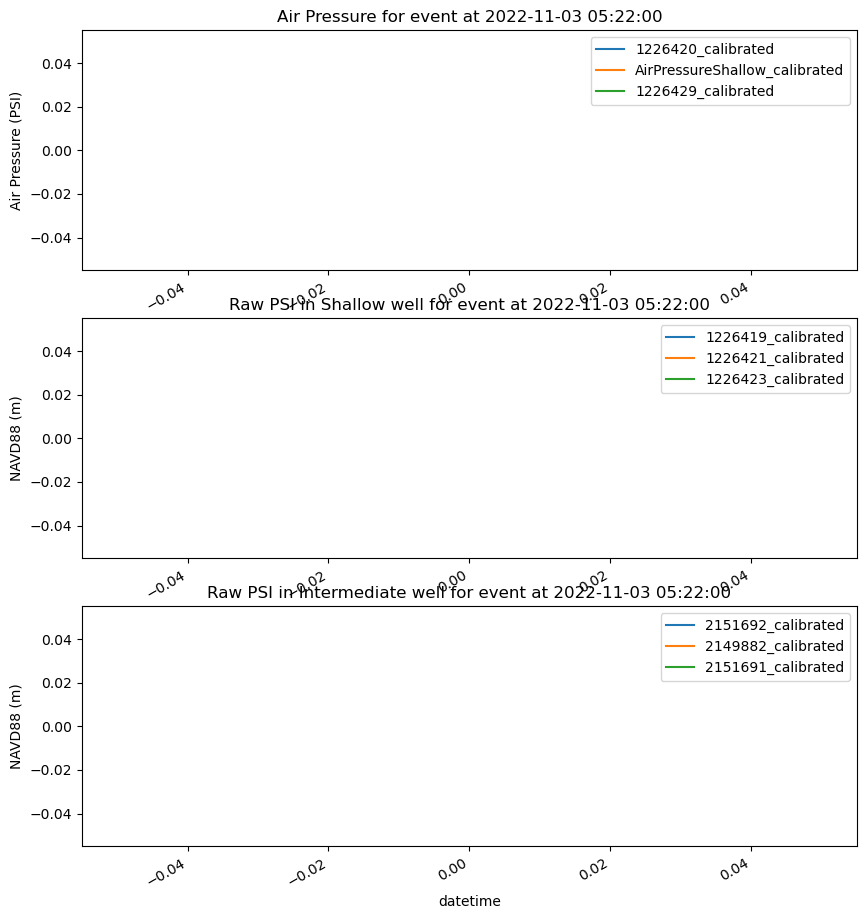

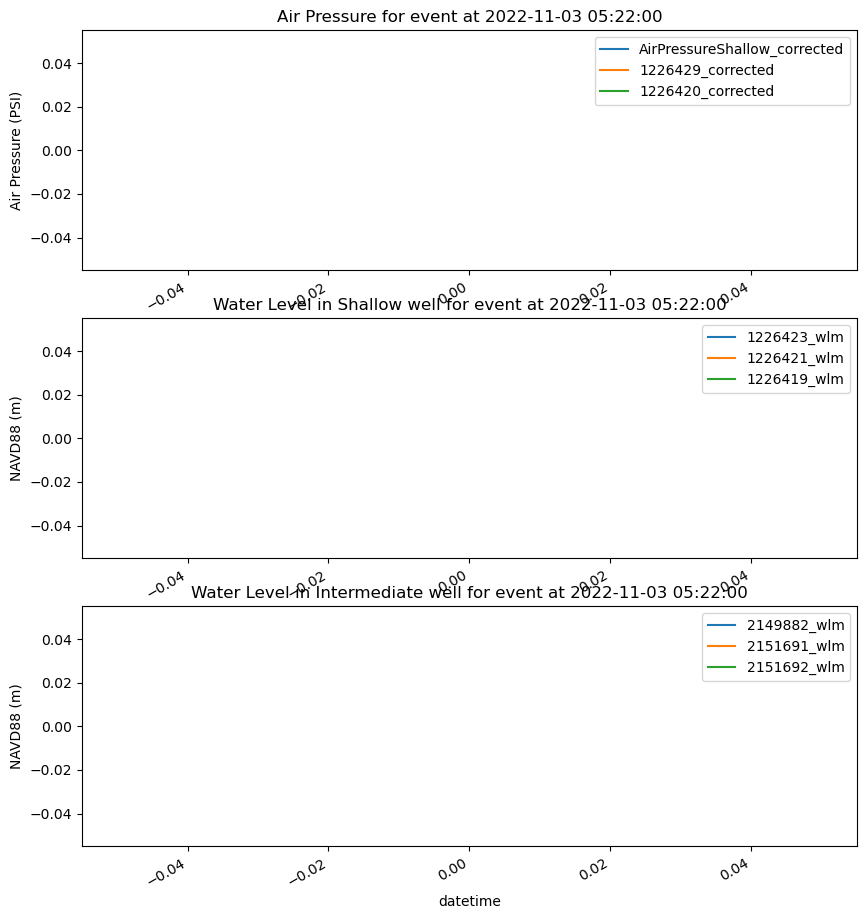

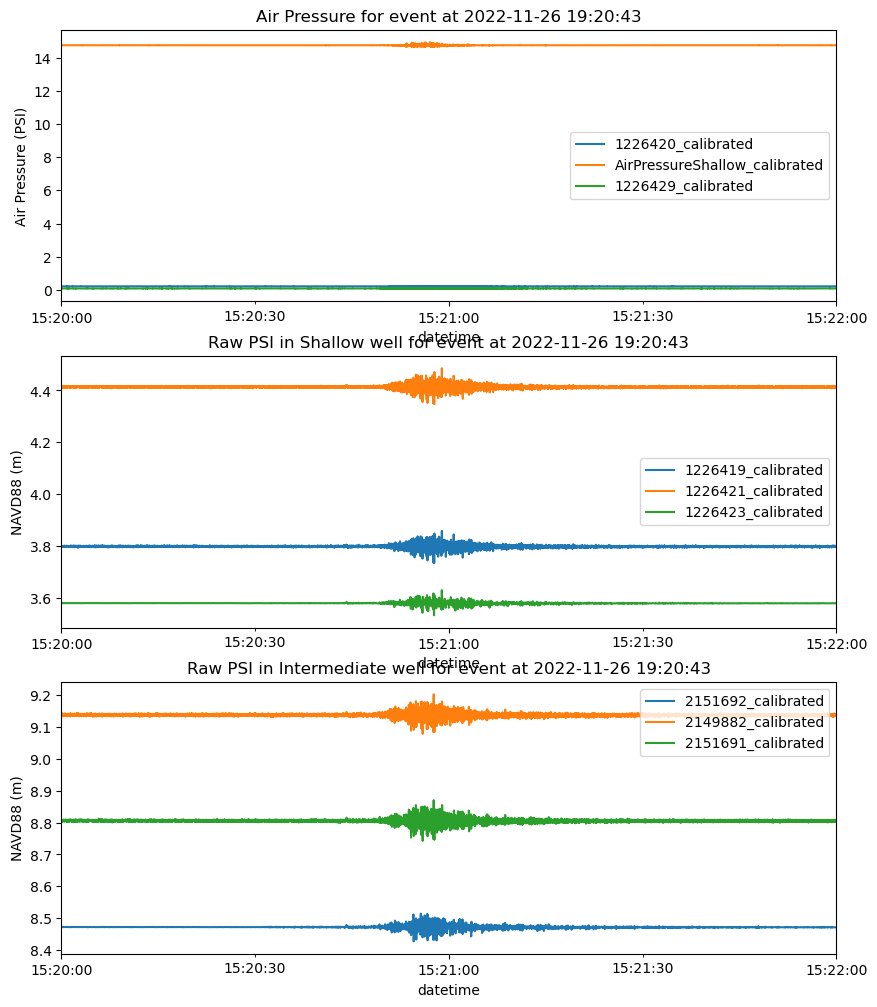

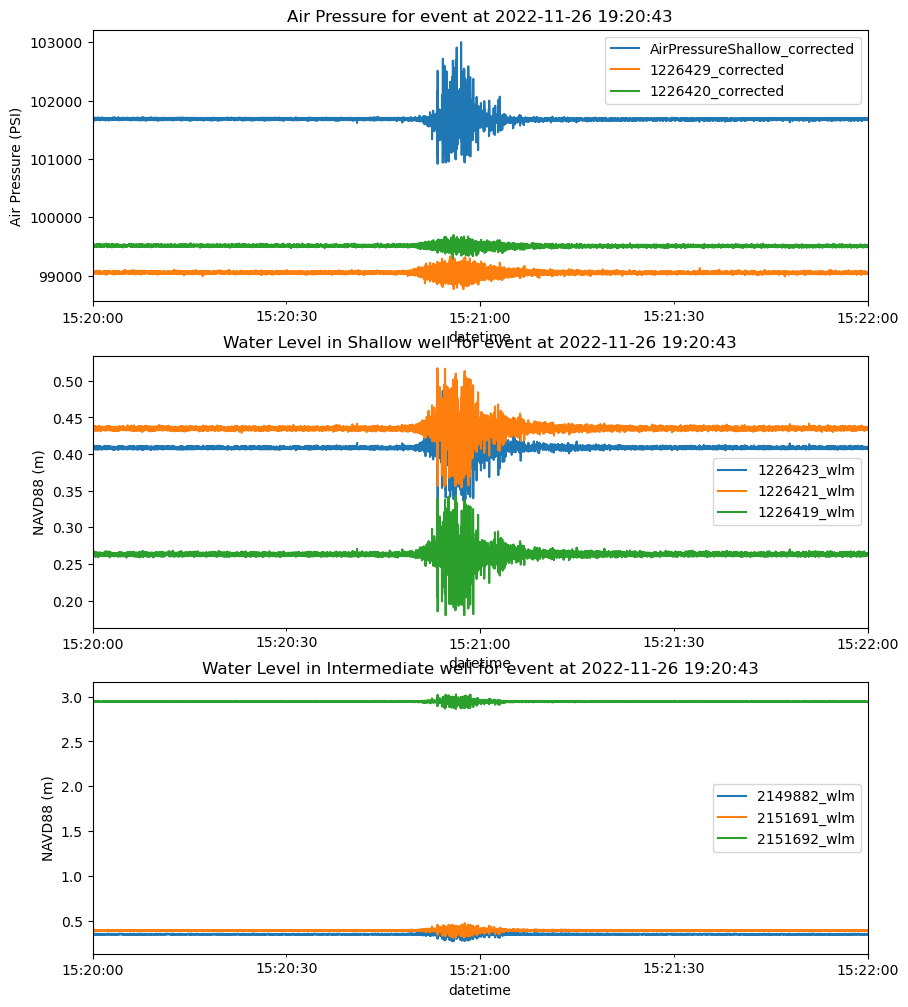

In [1]:
import os
import glob
import sys
import header
paths = header.setup_environment()
paths['SDS_TOP'] = '/data/SDS'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import obspy
sys.path.append(os.path.join(paths['Developer'], 'SoufriereHillsVolcano', 'lib'))
import SDS
import Spectrograms
import USF_instrument_responses
import libWellData as LLE
from obspy.clients.filesystem.sds import Client
from obspy.signal.cross_correlation import correlate, xcorr_max
from obspy.signal.trigger import coincidence_trigger
from pprint import pprint
import matplotlib.dates as dates
import libseisGT
import librockets as LR

##############################################################
# written for well data

def dataframe2stream(df):
    stream = obspy.Stream()
    for column in df.columns:
        if column=='datetime':
            continue
        if column.endswith('_PSI'):
            continue

        # Create Trace for each channel
        trace = obspy.Trace()

        if column=='AirPressureShallow_corrected':
            trace.id = '6S.Baro..HDD'
        elif column=='AirPressureDeep_corrected':
            trace.id = '6I.Baro..HDD'
        else:
            name = column.ljust(12, '_')
            if column in watercolumnsShallow:
                well = '6S'
                chan = 'WLM'
            elif column in watercolumnsIntermediate:
                well = '6I'
                chan = 'WLM'
            elif column in aircolumns:
                if column[-1]=='0':
                    well = '6S'
                else:
                    well = '6I'
                chan = 'HDD'
            else:
                continue
           
            trace.id = '.'.join((well, column[0:5], column[5:7], chan))
        trace.data = df[column].values   
        if trace.stats.channel=='WLM':
            trace.stats['units'] = 'mh20'
        elif trace.stats.channel=='HDD':
            trace.stats['units'] = 'Pa'

        mintime = df['datetime'].min()
        try:
            trace.stats.starttime = obspy.UTCDateTime(mintime.timestamp())  # Set the start time
        except:
            print(mintime, df.loc[0,'datetime'])
            trace.stats.starttime = obspy.UTCDateTime(df.iloc[0]['datetime'].timestamp())
        trace.stats.delta = df['datetime'].diff().median().total_seconds()  # Sampling rate (1 Hz in this example)
        
        stream += trace  # Add the trace to the stream
    print(stream)
    return stream


def intersect(df, cols):
    common_cols = list(set(df.columns) & set(cols))
    return common_cols


def maxamp(tr):
    return np.max(np.abs(tr.data))
'''
def remove_spikes(st):

    FEET_MAX = 21 # feet

    
    for tr in st:
        ma = maxamp(tr)


        if tr.stats.units == 'feet': # for when we had well data in feet in SDS
            tr.data[tr.data > FEET_MAX] = np.nan
            tr.data[tr.data < -1 * FEET_MAX] = np.nan   
                 

def add_snr(st, assoctime, threshold=1.5):
    nstime = max([st[0].stats.starttime, assoctime-240])
    netime = min([st[0].stats.endtime, assoctime-60])
    sstime = assoctime
    setime = min([st[0].stats.endtime, assoctime+120])    
    for tr in st:
        tr_noise = tr.copy().trim(starttime=nstime, endtime=netime)
        tr_signal = tr.copy().trim(starttime=sstime, endtime=setime)
        tr.stats['noise'] = np.nanmedian(np.abs(tr_noise.data))
        tr.stats['signal'] = np.nanmedian(np.abs(tr_signal.data))
        tr.stats['snr'] = tr.stats['signal']/tr.stats['noise']
        

def group_streams_for_plotting(st):
    groups = {}
    stationsWELL = ['6S', '6I']
    for station in stationsWELL:
        stationStream = st.select(network=station)
        #stationIDS = list(set([tr.id for tr in stationStream]))
        groups[station] = stationStream
    streamSA = st.select(network='FL')
    stationsSA = list(set([tr.stats.station for tr in streamSA]))
    for station in stationsSA:
        stationStream = streamSA.select(station=station)
        #stationIDS = list(set([tr.id for tr in stationStream]))
        groups[station] = stationStream
    #print(groups)
    return groups 
'''

sdsclient = Client(paths['SDS_TOP'])
thisSDSobj = SDS.SDSobj(paths['SDS_TOP'])

paths['PSI'] = os.path.join(paths['DROPBOX_DATA_TOP'], 'WellData', '05_DAILY_PSI')
paths['WLM'] = os.path.join(paths['DROPBOX_DATA_TOP'], 'WellData', '07_DAILY_WLM')
paths['EVENTS'] = os.path.join(paths['DROPBOX_DATA_TOP'], 'EVENTS')

paths['WWW_TOP'] = '/var/www/html/usfseismiclab.org/html/rocketcat'
paths['WWW_EVENTS']=os.path.join(paths['WWW_TOP'], 'EVENTS')
#paths['WWW_CONTINUOUS'] = os.path.join(paths['WWW_TOP'], 'CONTINUOUS')
paths['csv_launches'] = os.path.join(paths['WWW_TOP'], 'launches.csv')

launchesDF = LLE.removed_unnamed_columns(pd.read_csv(paths['csv_launches'], index_col=None, parse_dates=['datetime']))
#launchesDF['datetime']= pd.to_datetime(launchesDF['Date'] + ' ' +  launchesDF['Time'])
preseconds=120
eventseconds=120
postseconds=120
taperseconds=600
aircolumns = ['AirPressureShallow_corrected', 'AirPressureDeep_corrected', '1226420_corrected', '1226429_corrected']
watercolumnsShallow = ['1226421_wlm', '1226419_wlm', '1226423_wlm']
watercolumnsIntermediate = ['2149882_wlm', '2151691_wlm', '2151692_wlm']

aircolumnsRaw = ['AirPressureShallow_calibrated', 'AirPressureDeep_calibrated', '1226420_calibrated', '1226429_calibrated']
watercolumnsShallowRaw = ['1226421_calibrated', '1226419_calibrated', '1226423_calibrated']
watercolumnsIntermediateRaw = ['2149882_calibrated', '2151691_calibrated', '2151692_calibrated']

launchesDF['ontime']=None
launchesDF['offtime']=None
launchesDF['signalStrength']=None
launchesDF['Baro_amp']=None # units Pa
launchesDF['Baro_diff']=None # units Pa
launchesDF['6S_amp']=None # units mH20
launchesDF['6I_amp']=None # units mH20
launchesDF['6S_diff']=None #units mH20
launchesDF['6I_diff']=None #units mH20
launchesDF['6S_Pa']=None # units Pa
launchesDF['6I_Pa']=None # units Pa

# need to add a detector for sonic booms too!
for idx, eventrow in launchesDF.iterrows():
    # get start and end time. remember that spreadsheet is in UTC. well data are in local time but summer time is assumed throughout (UTC-4)
    launchtimeUTC = eventrow['datetime']

    # create event directory
    EVENTDIR = os.path.join(paths['WWW_EVENTS'], launchtimeUTC.isoformat())
    if not os.path.isdir(EVENTDIR):
        os.makedirs(EVENTDIR)  

    print('Processing launch at %s' % launchtimeUTC.strftime('%Y-%m-%d %H:%M:%S')) 

    stime = launchtimeUTC - pd.Timedelta(seconds=preseconds) - pd.Timedelta(hours=4)
    etime = launchtimeUTC + pd.Timedelta(seconds=eventseconds+postseconds) - pd.Timedelta(hours=4)
    welldayfile0 = None
    if stime.day != eventrow['datetime'].day:
        welldayfile0 = os.path.join(paths['WLM'],stime.strftime('%Y%m%d.pkl'))
        if not os.path.isfile(welldayfile0):
            welldayfile0 = None
    if welldayfile0:
        welldaydf0 = pd.read_pickle(welldayfile0)
    else:
        welldaydf0 = None
    welldayfile = os.path.join(paths['WLM'],launchtimeUTC.strftime('%Y%m%d.pkl'))

    if os.path.isfile(welldayfile):
        welldaydf = pd.read_pickle(welldayfile)
        if isinstance(welldaydf0, pd.DataFrame):
            welldaydf = pd.concat([welldaydf0, welldaydf])
        #welldaydf = welldaydf.filter(regex='^(?!.*wldiff$)')
        print(f'Subsetting {os.path.basename(welldayfile)} from {stime} to {etime}')
        welldaydf['datetime'] = pd.to_datetime(welldaydf['datetime'])
        mask = (welldaydf['datetime']>=stime) & (welldaydf['datetime']<=etime)
        welldaydf = welldaydf.loc[mask]
        welldaydf = welldaydf.dropna(subset=['datetime'])

        if len(welldaydf)>0:
            channelsdf = pd.DataFrame(columns=['nslc', 'amplitude', 'DC_before', 'DC_after', 'DC_diff', 'units', 'corr_coef', 'shift'])

            # fix units
            for col in welldaydf.columns:
                if col in aircolumns:
                    welldaydf[col] = welldaydf[col] * 6894.76 # PSI to Pascals

            allcols = ['datetime'] + aircolumns + watercolumnsShallow + watercolumnsIntermediate
            st = dataframe2stream(welldaydf[intersect(welldaydf, allcols)])

            best_trig = LR.detectEvent(st)
            pad_secs = 10
            trigtime = obspy.UTCDateTime(launchtimeUTC)
            duration = eventseconds
            if len(best_trig)>0:    
                trigtime = best_trig['time']
                duration = best_trig['duration']
            trimtime0 = LR.floor_minute(trigtime-pad_secs)
            trimtime1 = LR.ceil_minute(trigtime+duration+pad_secs)
            st.trim(starttime=trimtime0, endtime=trimtime1)
            print(st)
            welldaydf = welldaydf[welldaydf['datetime'].between(pd.to_datetime(trimtime0.datetime), pd.to_datetime(trimtime1.datetime))]    

            fh, axs = plt.subplots(3,1, figsize=(10,12))
            welldaydf.plot(ax=axs[0], x='datetime', y=intersect(welldaydf, aircolumnsRaw), ylabel='Air Pressure (PSI)', title=f'Air Pressure for event at {launchtimeUTC}')
            welldaydf.plot(ax=axs[1], x='datetime', y=intersect(welldaydf, watercolumnsShallowRaw), ylabel='Water Pressure (PSI)', title=f'Raw PSI in Shallow well for event at {launchtimeUTC}')
            welldaydf.plot(ax=axs[2], x='datetime', y=intersect(welldaydf, watercolumnsIntermediateRaw), ylabel='Water Pressure (PSI)', title=f'Raw PSI in Intermediate well for event at {launchtimeUTC}')
            fh.savefig(os.path.join(EVENTDIR, 'well_calibrated.png'))

            fh, axs = plt.subplots(3,1, figsize=(10,12))
            welldaydf.plot(ax=axs[0], x='datetime', y=intersect(welldaydf, aircolumns), ylabel='Air Pressure (PSI)', title=f'Air Pressure for event at {launchtimeUTC}')
            welldaydf.plot(ax=axs[1], x='datetime', y=intersect(welldaydf, watercolumnsShallow), ylabel='NAVD88 (m)', title=f'Water Level in Shallow well for event at {launchtimeUTC}')
            welldaydf.plot(ax=axs[2], x='datetime', y=intersect(welldaydf, watercolumnsIntermediate), ylabel='NAVD88 (m)', title=f'Water Level in Intermediate well for event at {launchtimeUTC}')
            fh.savefig(os.path.join(EVENTDIR, 'water_levels.png'))
            continue
            
            welldaydf.to_pickle(os.path.join(EVENTDIR, 'welldata.pkl'))

            st = dataframe2stream(welldaydf)
            best_trig = LR.detectEvent(st)
            pad_secs = 10
            if len(best_trig)>0:    

                st3 = st.copy()
                st3.trim(starttime=best_trig['time']-pad_secs, endtime=best_trig['time']+pad_secs+best_trig['duration'])
                st3.write(os.path.join(EVENTDIR, 'welldata.mseed'), format='MSEED')
                AP6S = st3.select(id='6S.Baro..HDD')
                bool_xcorr = False
                if len(AP6S)==1:
                    bool_xcorr = True
                    AP6S = AP6S.copy()[0].detrend()
                for channel in ['HDD', 'WLM']:
                    if channel=='HDD':
                        units = 'Pa'
                        titlestr = f'Air Pressure (Pa) for Event {launchtimeUTC}'
                    elif channel=='WLM':
                        units = 'm'
                        titlestr = f'Water Level (m) for Event {launchtimeUTC}'    
                    st4 = st3.select(channel=channel)

                    # time series plots on raw Stream
                    st4.plot(equal_scale=True, outfile=os.path.join(EVENTDIR, f'stream_{channel}.png'));


                    # we do the spectral processing on a detrended Stream
                    st5 = st4.copy()
                    st5.detrend('linear')
                    spobj = Spectrograms.icewebSpectrogram(stream=st5)
                    spobj = spobj.precompute()
                    spobj.plot(fmin=0.1, fmax=50.0, equal_scale=True, title=titlestr, outfile=os.path.join(EVENTDIR, f'sgram_{channel}.png'))
                    #st3.spectrogram()
                    spobj.compute_amplitude_spectrum(compute_bandwidth=True)
                    spobj.plot_amplitude_spectrum(normalize=True, title=titlestr)  
                    plt.savefig(os.path.join(EVENTDIR, f'spectrum_{channel}.png'))
                
                    for i,tr in enumerate(st5):
                        if bool_xcorr:
                            correlation = correlate(tr, AP6S, 100)
                            bestshift, bestvalue = xcorr_max(correlation, abs_max=True)
                        tr_before = st4[i].copy()
                        tr_before = tr_before.trim(starttime=best_trig['time']-pad_secs, endtime=best_trig['time']-pad_secs/2)
                        tr_after = st4[i].copy()
                        tr_after = tr_after.trim(starttime=best_trig['time']+best_trig['duration']+pad_secs/2, endtime=best_trig['time']+best_trig['duration']+pad_secs)
                        DC_before=np.median(tr_before.data)
                        DC_after=np.median(tr_after.data)
                        new_row = {'nslc':tr.id, 'amplitude':tr.max(), 'DC_before':DC_before, 'DC_after':DC_after, 'DC_diff':DC_after-DC_before, 'units':units}
                        #nErow['bw_min']=
                        #new_row['bw_max']=
                        new_row['corr_coef']=bestvalue
                        new_row['shift']=bestshift
                        channelsdf.loc[len(channelsdf)] = new_row
                display(channelsdf)
                ''' what statistics can we add to the dataframe for each event?
                * maximum absolute amplitude (from mean)
                * bandwidth?
                * detection on and off time
                * correlations between each trace - and a median correlation?
                * correlation best time lag between each trace 
                * DC level before and after
                * summary or event level (or per station) stats can go in the event catalog, more detailed per channel stats can go in the event
                '''

            if len(channelsdf)>0:
                # save channelsdf
                channelsdf.to_csv(os.path.join(EVENTDIR, 'channelsDF.csv'), index=False)

                # add content to launchesDF for this event
                airdf = channelsdf[channelsdf['nslc'].str.contains('.Baro.')]
                waterdf = channelsdf[channelsdf['nslc'].str.endswith('WLM')]
                water6S = waterdf[waterdf['nslc'].str.startswith('6S')]
                water6I = waterdf[waterdf['nslc'].str.startswith('6I')]
                launchesDF.at[idx, 'signalStrength'] = np.sum(best_trig['cft_peaks'])
                launchesDF.at[idx, 'Baro_amp'] = airdf['amplitude'].abs().mean(axis=0)
                launchesDF.at[idx,'Baro_diff'] = airdf['DC_diff'].mean(axis=0)
                launchesDF.at[idx, '6S_amp'] = water6S['amplitude'].abs().mean(axis=0)
                launchesDF.at[idx, '6I_amp'] = water6I['amplitude'].abs().mean(axis=0)
                launchesDF.at[idx, '6S_diff'] = water6S['DC_diff'].mean(axis=0)
                launchesDF.at[idx, '6I_diff'] = water6I['DC_diff'].mean(axis=0)
    else:
        print(f'{welldayfile} not found')
       

In [2]:
         
# remove any blank columns in launchesDF
launchesDF = launchesDF.dropna(axis=1, how='all')
if '6S_Pa' in launchesDF: # we have well data
    display(launchesDF.columns)
    launchesDF['6S_Pa'] = launchesDF['6S_amp']*9806.65
    launchesDF['6I_Pa'] = launchesDF['6I_amp']*9806.65
    launchesDF.to_csv(os.path.join(paths['WWW_EVENTS'], 'launchesDF.csv'))
    launchesDF.plot(x='datetime',y=['Baro_amp', '6S_Pa', '6I_Pa'], style='o', ylabel='Pa', title='Comparing pressures in air, and in each well')
    plt.savefig(os.path.join(paths['WWW_EVENTS'], 'catalog_pascals.png'))
    display(launchesDF[['datetime', 'Baro_amp', '6S_Pa', '6I_Pa']])